# Examining Heavy Traffic Indicators on I-94

This project goes through the traffic data gathered on the I-94 insterstate road. For those that are unfamiliar, like me, I-94 is a long highway. If you drove at a hundred kilometers per hour continuously from end to end, it will take you over 24 hours. Fortunately, we'll focus only at one point on this road. And though this isn't a project about driving (I don't know how to drive) we could get a sense of what influences drivers and traffic overall.

The [dataset](https://archive.ics.uci.edu/dataset/492/metro+interstate+traffic+volume) from UCI used in this project counts the traffic going westward passing by a point somewhere between Mineapolis and St. Paul. 

![i94.png](./i94.png)


In [192]:
# Import libraries
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
%matplotlib inline
import seaborn as sns


from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Dataset

In [98]:
# Load the dataset
i_94 = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')

There are 9 columns in this dataset. 
- `traffic_volume` is the target column that reflects the number of vehicles counted every hour.
- `date_time` is the hour the datapoint is taken in datetime format.
- `holiday` indicates what holiday is observed on that day
- `temp`, `rain_1h`, `snow_1h`, `clouds_all`, `weather_main`, `weather_description` are the ambient conditions


In [99]:
pd.DataFrame(list(i_94.columns), columns=["Columns"])

,Columns
0,holiday
1,temp
2,rain_1h
3,snow_1h
4,clouds_all
5,weather_main
6,weather_description
7,date_time
8,traffic_volume


In [100]:
i_94.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


**Missing Values**

We see that there are missing values in the `holiday` column. The non-holidays are left blank and the world moves on. The rest of the columns are complete.

In [101]:
i_94.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              61 non-null     object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


**Distribution**

Traffic volumes near 5000 or 1000 make up the majority of the dataset.

<Axes: >

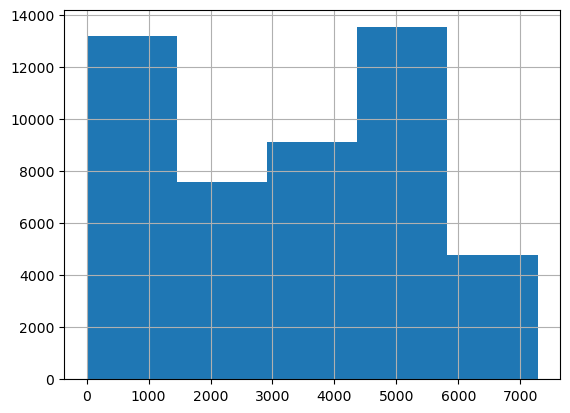

In [102]:
i_94['traffic_volume'].hist(bins=5)

In [103]:
traffic_volume_series = i_94['traffic_volume']
traffic_volume_series.describe()

count    48204.000000
mean      3259.818355
std       1986.860670
min          0.000000
25%       1193.000000
50%       3380.000000
75%       4933.000000
max       7280.000000
Name: traffic_volume, dtype: float64

**Duplicates**

We'll take note of the duplicate values in the date_time column. The duplicates are necessary to accommodate changes in the weather within the hour during the hourly data gathering. Weathers do what they do, they just don't sit still for an hour all the time

In [104]:
duplicates = i_94.loc[i_94.duplicated(subset=['date_time'], keep=False), ["weather_main", "date_time", "traffic_volume"]]
duplicates

,weather_main,date_time,traffic_volume
178,Rain,2012-10-10 07:00:00,6793
179,Drizzle,2012-10-10 07:00:00,6793
180,Rain,2012-10-10 08:00:00,6283
181,Drizzle,2012-10-10 08:00:00,6283
182,Rain,2012-10-10 09:00:00,5680
...,...,...,...
48173,Clouds,2018-09-29 19:00:00,3818
48192,Rain,2018-09-30 14:00:00,4380
48193,Drizzle,2018-09-30 14:00:00,4380
48194,Rain,2018-09-30 15:00:00,4302


### Time of Day

To start our analysis, let's look the average traffic volume at each time of the day. Let's do the following:
1. Remove the duplicate values in the `date_time` column. This isn't really necessary since we will be grouping and getting the mean by `hour` but it's a good way avoid errors in case we suddenly switch the aggregation to `sum`.
2. Extract the hour from the datetime formatted `date_time` column
3. Group dataset by hour and get the mean of the traffic volume
4. Convert hour into a reader friendly string format

In [105]:
# Time of data versus traffic volume

i_94_time = i_94.copy()
i_94_time = i_94_time.drop_duplicates(subset=['date_time'], keep='first') # Drop duplicates
i_94_time["date_time"] = pd.to_datetime(i_94_time["date_time"])
i_94_time['hour'] = i_94_time['date_time'].dt.hour
time_hr_traffic_volume = i_94_time.groupby('hour')['traffic_volume'].mean()
time_hr_traffic_volume.index = time_hr_traffic_volume.index.map(convert_to_am_pm) # Convert to AM/PM

print(time_hr_traffic_volume.index)

Index(['12 AM', '1 AM', '2 AM', '3 AM', '4 AM', '5 AM', '6 AM', '7 AM', '8 AM',
       '9 AM', '10 AM', '11 AM', '12 PM', '1 PM', '2 PM', '3 PM', '4 PM',
       '5 PM', '6 PM', '7 PM', '8 PM', '9 PM', '10 PM', '11 PM'],
      dtype='object', name='hour')


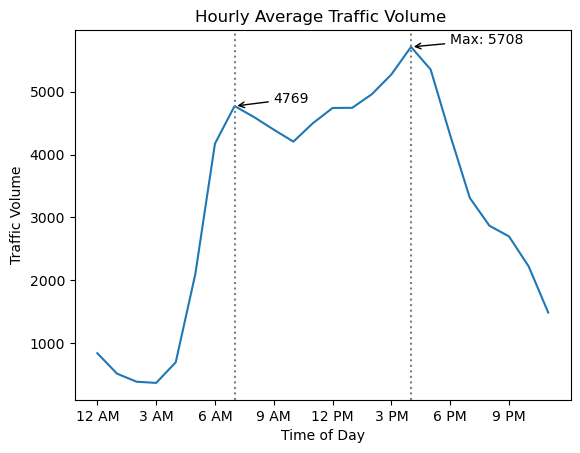

In [106]:
time_hr_traffic_volume = i_94_time.groupby('hour')['traffic_volume'].mean()

# Create the line plot
time_hr_traffic_volume.plot.line()

# Find the maximum value and its corresponding index
max_value = int(time_hr_traffic_volume.max())
max_index = int(time_hr_traffic_volume.idxmax())

min_value = int(time_hr_traffic_volume.min())
min_index = int(time_hr_traffic_volume.idxmin())

am_7 = 7
tv_am_7 = int(time_hr_traffic_volume[am_7])


# Annotate the maximum point on the plot
plt.annotate(f'Max: {max_value}', xy=(max_index, max_value), xytext=(max_index + 2, max_value + 50), arrowprops=dict(facecolor='black', arrowstyle='->'))
plt.annotate(f'{tv_am_7}', xy=(am_7, tv_am_7), xytext=(am_7 + 2, tv_am_7 + 50), arrowprops=dict(facecolor='black', arrowstyle='->'))

# Add labels and title
plt.xlabel('Time of Day')
plt.ylabel('Traffic Volume')
plt.axvline(x=max_index, color='gray', linestyle='dotted')
plt.axvline(x=am_7, color='gray', linestyle='dotted')
plt.title('Hourly Average Traffic Volume ')

# Show the plot
plt.xticks(range(0, 24, 3), ['12 AM', '3 AM', '6 AM', '9 AM', '12 PM', '3 PM', '6 PM', '9 PM'])
plt.xticks(range(0, 24, 3))
plt.show()


The average traffic peaks at 4 PM and drops to below 4000 by early evening.

## Holidays

Let's look at the holiday column and inspect the corresponding date_time.

In [107]:
i_94_hol = i_94.copy()
i_94_hol.loc[i_94_hol["holiday"].notnull(), ["holiday", "date_time"]]

,holiday,date_time
126,Columbus Day,2012-10-08 00:00:00
1123,Veterans Day,2012-11-12 00:00:00
1370,Thanksgiving Day,2012-11-22 00:00:00
2360,Christmas Day,2012-12-25 00:00:00
2559,New Years Day,2013-01-01 00:00:00
...,...,...
44441,Memorial Day,2018-05-28 00:00:00
45547,Independence Day,2018-07-04 00:00:00
46936,State Fair,2018-08-23 00:00:00
47330,Labor Day,2018-09-03 00:00:00


We can see that if the day is a holiday only the row for the 12 midnight gets marked with the holiday name.
Since a holiday is for the entire day, we'll mark all the hours in that day with the same holiday name.
1. Add a column for the stringified date_time
2. Make the `date_time` column unique
2. Find the non null rows of the holiday column
3. Assign the same holiday name to all the rows with the same date (eg. if the row with a `date_time` value of `2012-10-08 01:00` is "Columbus Day" then we'll set "Columbus Day" to the rows with `date_time` values of `2012-10-08 02:00` to `2012-10-08 23:00`)

We'll compare two implementations that achieve the targets above. The first one uses a for-loop, which most people are allergic to. The second uses groupby and transform combo.

Here's the first one. Its execution takes 2.5s to complete.

In [108]:
# Create a new column for the date as a string
i_94_hol = i_94.copy()

i_94_hol = i_94_hol.drop_duplicates(subset=['date_time'], keep='first')

non_null_dates = get_non_null_dates(i_94_hol) # Get the dates that are holidays 

# Create a list of unique dates
unique_dates = non_null_dates['date_time'].unique()

# Iterate over the unique dates
for date in unique_dates:
    # Get the corresponding holiday value for the date
    holiday = non_null_dates.loc[non_null_dates['date_time'].str.split().str[0] == date.split()[0], 'holiday'].values[0]
    i_94_hol["holiday"] = np.where(i_94_hol['date_time'].str.split().str[0] == date.split()[0], holiday, i_94_hol['holiday'])
    
    # Set the holiday value for all rows with the same date
    # i_94_hol.loc[i_94_hol['date_time'].str.split().str[0] == date.split()[0], 'holiday'] = holiday
    
    
i_94_hol["hour"] = pd.to_datetime(i_94_hol["date_time"]).dt.hour

The next one completes in 0.2s.

In [109]:
i_94_hol = i_94.copy()

# Ensure 'date_time' is a datetime column
i_94_hol['date_time'] = pd.to_datetime(i_94_hol['date_time'])

# Create a new column for just the date part
i_94_hol['date'] = i_94_hol['date_time'].dt.date

# Use transform with a lambda function to fill 'holiday' within each group
# The lambda function takes the first non-null 'holiday' value in each group and fills the group with it
i_94_hol['holiday'] = i_94_hol.groupby('date')['holiday'].transform(lambda x: x.dropna().iloc[0] if not x.dropna().empty else np.nan)

# Optionally, drop the temporary 'date' column if it's no longer needed
i_94_hol.drop(columns=['date'], inplace=True)


But the output is the same. All the rows with the same date get the same holiday label. As an example let's see the rows for `2012-10-08`

In [110]:
i_94_hol[i_94_hol['holiday'].notnull()][:25]

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
126,Columbus Day,273.08,0.0,0.0,20,Clouds,few clouds,2012-10-08 00:00:00,455
127,Columbus Day,272.62,0.0,0.0,20,Clouds,few clouds,2012-10-08 01:00:00,336
128,Columbus Day,271.78,0.0,0.0,1,Clear,sky is clear,2012-10-08 02:00:00,265
129,Columbus Day,271.05,0.0,0.0,1,Clear,sky is clear,2012-10-08 03:00:00,314
130,Columbus Day,270.63,0.0,0.0,1,Clear,sky is clear,2012-10-08 04:00:00,779
131,Columbus Day,270.33,0.0,0.0,1,Clear,sky is clear,2012-10-08 05:00:00,2571
132,Columbus Day,269.61,0.0,0.0,20,Clouds,few clouds,2012-10-08 06:00:00,5563
133,Columbus Day,270.01,0.0,0.0,20,Clouds,few clouds,2012-10-08 07:00:00,6676
134,Columbus Day,271.23,0.0,0.0,20,Clouds,few clouds,2012-10-08 08:00:00,5966
135,Columbus Day,273.71,0.0,0.0,20,Clouds,few clouds,2012-10-08 09:00:00,4832


If we divide the dataset into different years and take the average traffic volume for every hour we'll get the graph below.

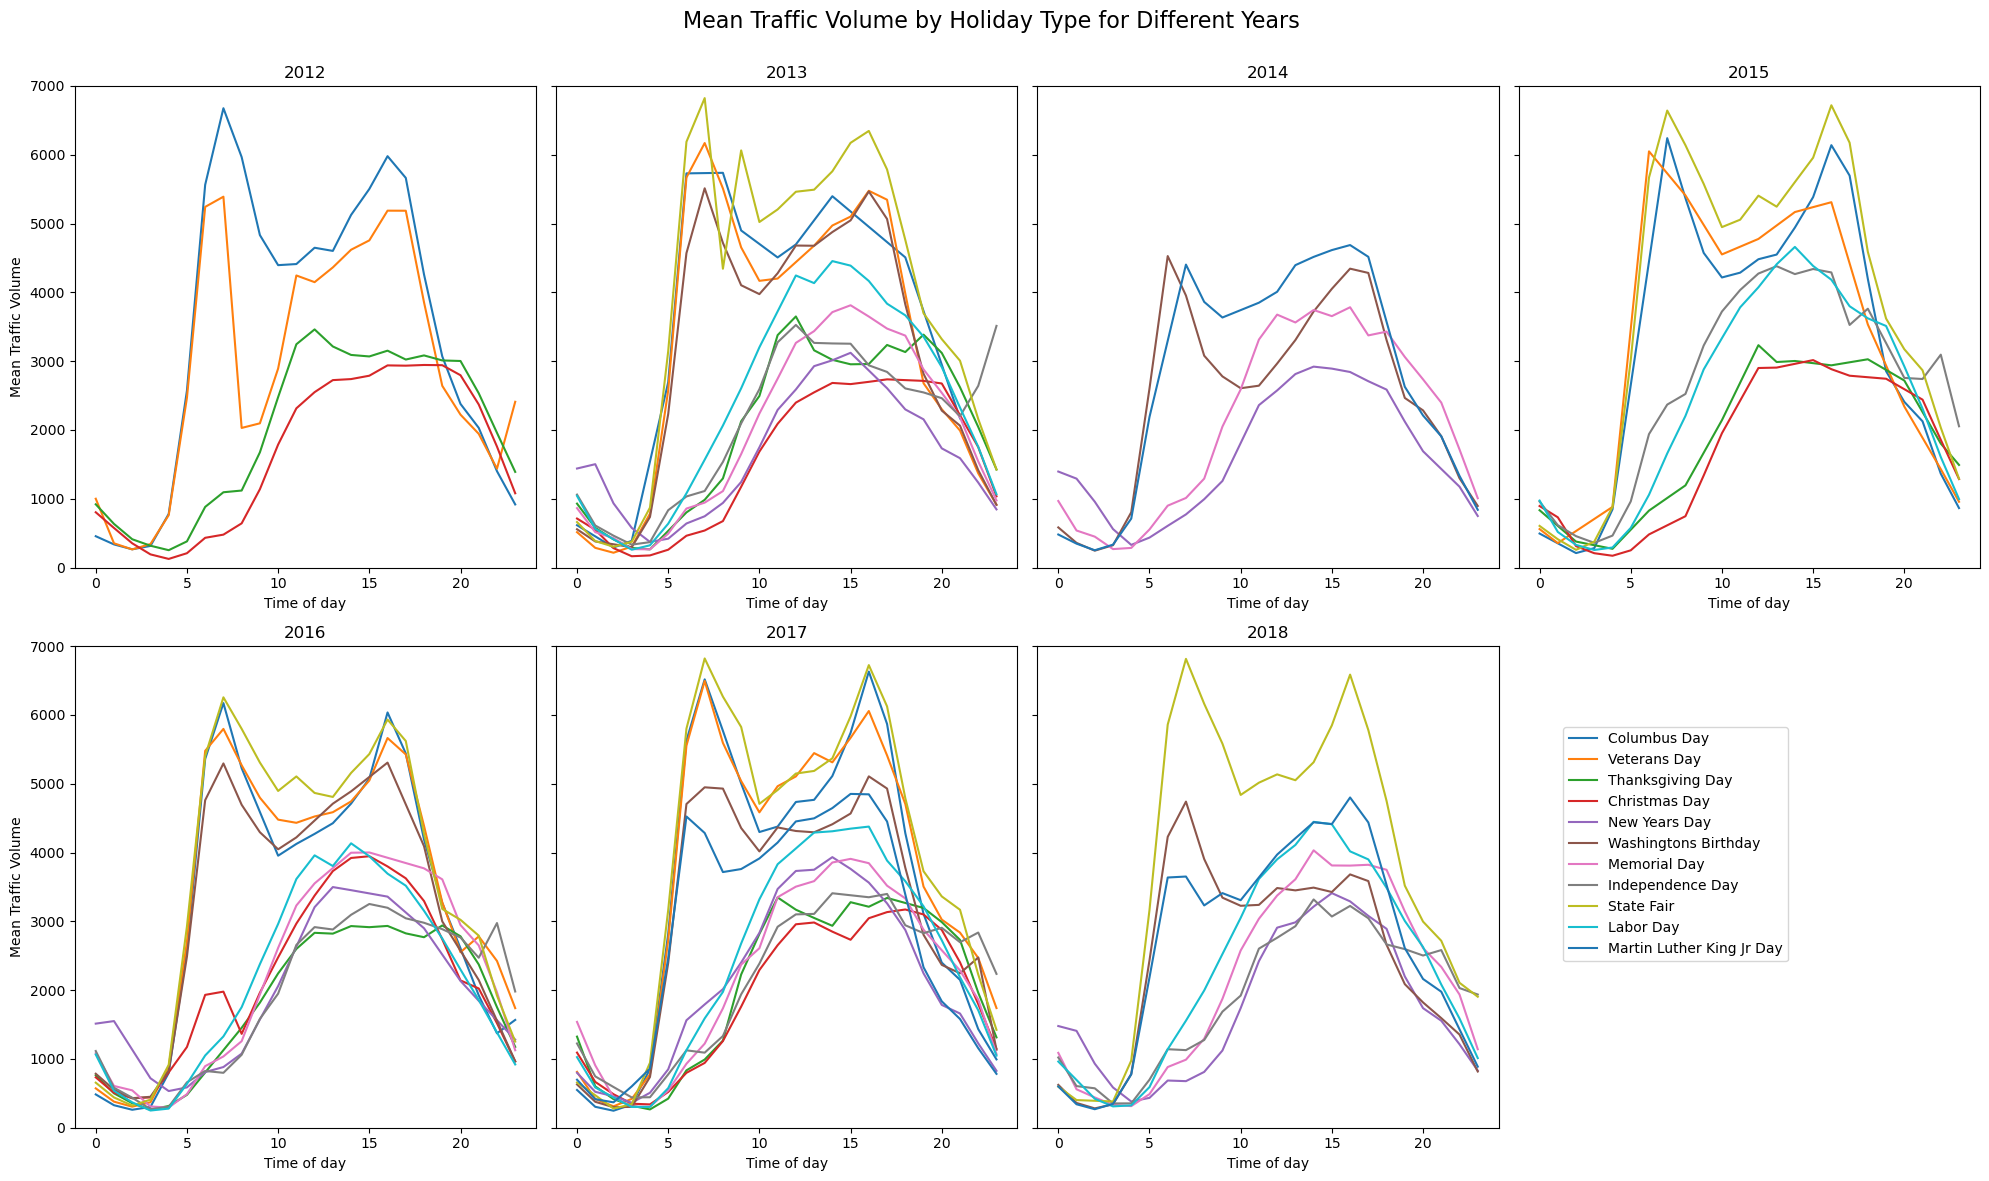

In [111]:
i_94_hol["hour"] = pd.to_datetime(i_94_hol["date_time"]).dt.hour

plot_holiday_traffic_volume_comparison(i_94_hol, [ 2012, 2013, 2014, 2015, 2016, 2017, 2018], groupby_cols=['hour','holiday'])

Comparing the holidays for every from 2012 to 2018 we can see that the most traffic happens on `State Fair` holidays and not so much on Christmas and New Year.

The dataset only has 4 declared holidays for the years 2012 and 2014. We may have to research further on why this is.

In [112]:
yr_bool = i_94_hol['date_time'].dt.year == 2014
df_hol_2014 = pd.DataFrame(i_94_hol[yr_bool]["holiday"].dropna().unique(), columns=["Holidays for 2014"])
yr_bool = i_94_hol['date_time'].dt.year == 2012
df_hol_2012 = pd.DataFrame(i_94_hol[yr_bool]["holiday"].dropna().unique(), columns=["Holidays for 2012"])
df_hol_2012.join(df_hol_2014, how='outer')

,Holidays for 2012,Holidays for 2014
0,Columbus Day,New Years Day
1,Veterans Day,Martin Luther King Jr Day
2,Thanksgiving Day,Washingtons Birthday
3,Christmas Day,Memorial Day


The heat map below summarizes the traffic volume per hour for all the years combined.

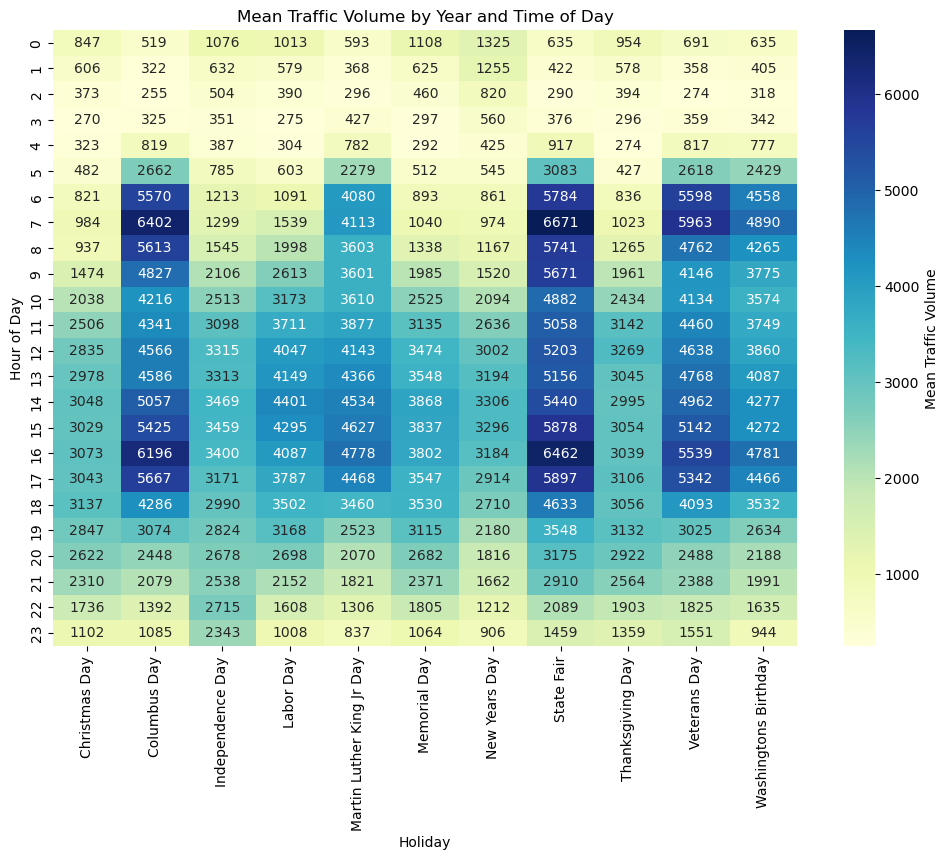

In [113]:
plot_holiday_traffic_volume_heatmap(i_94_hol, gby_col='holiday')

This part of the  I_94 road gets busy on State Fair holidays. Perhaps this season rouses the people to drive to the State Fair grounds. Traffic on this holiday is double the traffic on Christmas Day.

### Day of the Week

Now we'll what day of the week the I-94 road is busiest. This time we'll narrow down the time to within 7am and 7pm when the road is most active.

In [114]:
i_94_dow = i_94.copy()
i_94_dow["date_time"] = pd.to_datetime(i_94_dow["date_time"])
i_94_dow["day_of_week"] = i_94_dow["date_time"].dt.day_of_week
i_94_dow["hour"] = i_94_dow["date_time"].dt.hour


# Group the dataframe by day_of_week and calculate the average traffic volume
active_time_bool = (i_94_dow['hour'] >= 7) & (i_94_dow['hour'] <= 19)
traffic_volume_avg = i_94_dow[active_time_bool].groupby('day_of_week')['traffic_volume'].mean()


friday_bool = i_94_dow["day_of_week"]==4
tvol_gby_day_hr  = i_94_dow[friday_bool & active_time_bool].groupby(["day_of_week", "hour"])["traffic_volume"].mean()

weekend_bool = (i_94_dow["day_of_week"]==5) | (i_94_dow["day_of_week"]==6)
tvol_gby_day_hr_weekend  = i_94_dow[weekend_bool & active_time_bool].groupby(["hour"])["traffic_volume"].mean()

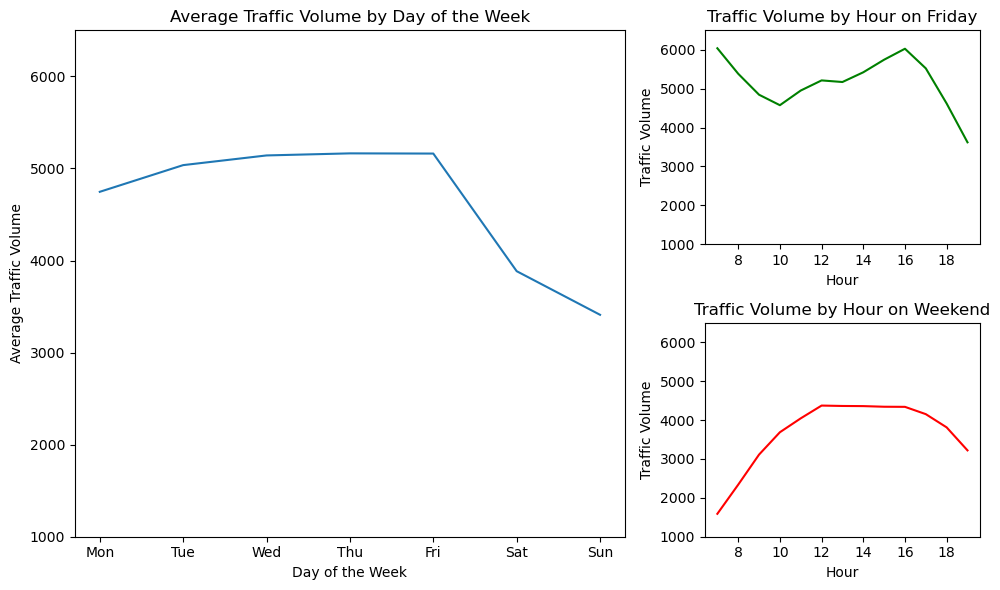

In [115]:

# Create figure
fig = plt.figure(figsize=(10, 6))

# Create a GridSpec with 2 rows and 2 columns
# The left column spans both rows and is twice as wide as the two right columns
gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1], height_ratios=[1, 1])

# Create subplots
ax1 = fig.add_subplot(gs[:, 0]) # Spans all rows in the first column
ax2 = fig.add_subplot(gs[0, 1]) # Top right subplot
ax3 = fig.add_subplot(gs[1, 1]) # Bottom right subplot

# Plot data in each subplot (example plots)
ax1.plot(traffic_volume_avg.index, traffic_volume_avg, label='Avg Traffic Volume')
ax1.set_title('Average Traffic Volume by Day of the Week')
ax1.set_xlabel('Day of the Week')
ax1.set_ylabel('Average Traffic Volume')
ax1.set_xticks(traffic_volume_avg.index)
ax1.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax1.set_ylim(1000, 6500)

# Example plot for ax2 and ax3
ax2.plot(tvol_gby_day_hr.reset_index()["hour"], tvol_gby_day_hr.reset_index()["traffic_volume"], color='green', label='Friday Traffic Volume')
ax2.set_title('Traffic Volume by Hour on Friday')
ax2.set_xlabel('Hour')
ax2.set_ylabel('Traffic Volume')
ax2.set_ylim(1000, 6500)

ax3.plot(tvol_gby_day_hr_weekend.reset_index()["hour"], tvol_gby_day_hr_weekend.reset_index()["traffic_volume"], color='red', label='Weekend Traffic Volume')
ax3.set_title('Traffic Volume by Hour on Weekend')
ax3.set_xlabel('Hour')
ax3.set_ylabel('Traffic Volume')
ax3.set_ylim(1000, 6500)


ax2.xaxis.set_major_locator(MaxNLocator(integer=True)) # Display integer ticks on x-axis
ax3.xaxis.set_major_locator(MaxNLocator(integer=True)) # Display integer ticks on x-axis

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

The road gets crowded at 7am  and 4pm especially on thursdays and fridays as the weekend approaches. On weekends, traffic builds up later in the day and peaks below 4500 on average.

### MONTHS

Knowing what the daily traffic is like, we'll extend our curiosity to monthly traffic behaviors. We'll still concentrate on the most active times of the day (7am to 7pm). Living near the Pacific all my life, I've never seen snow before but I expect that the winter cold months are less busy than on warmer months.

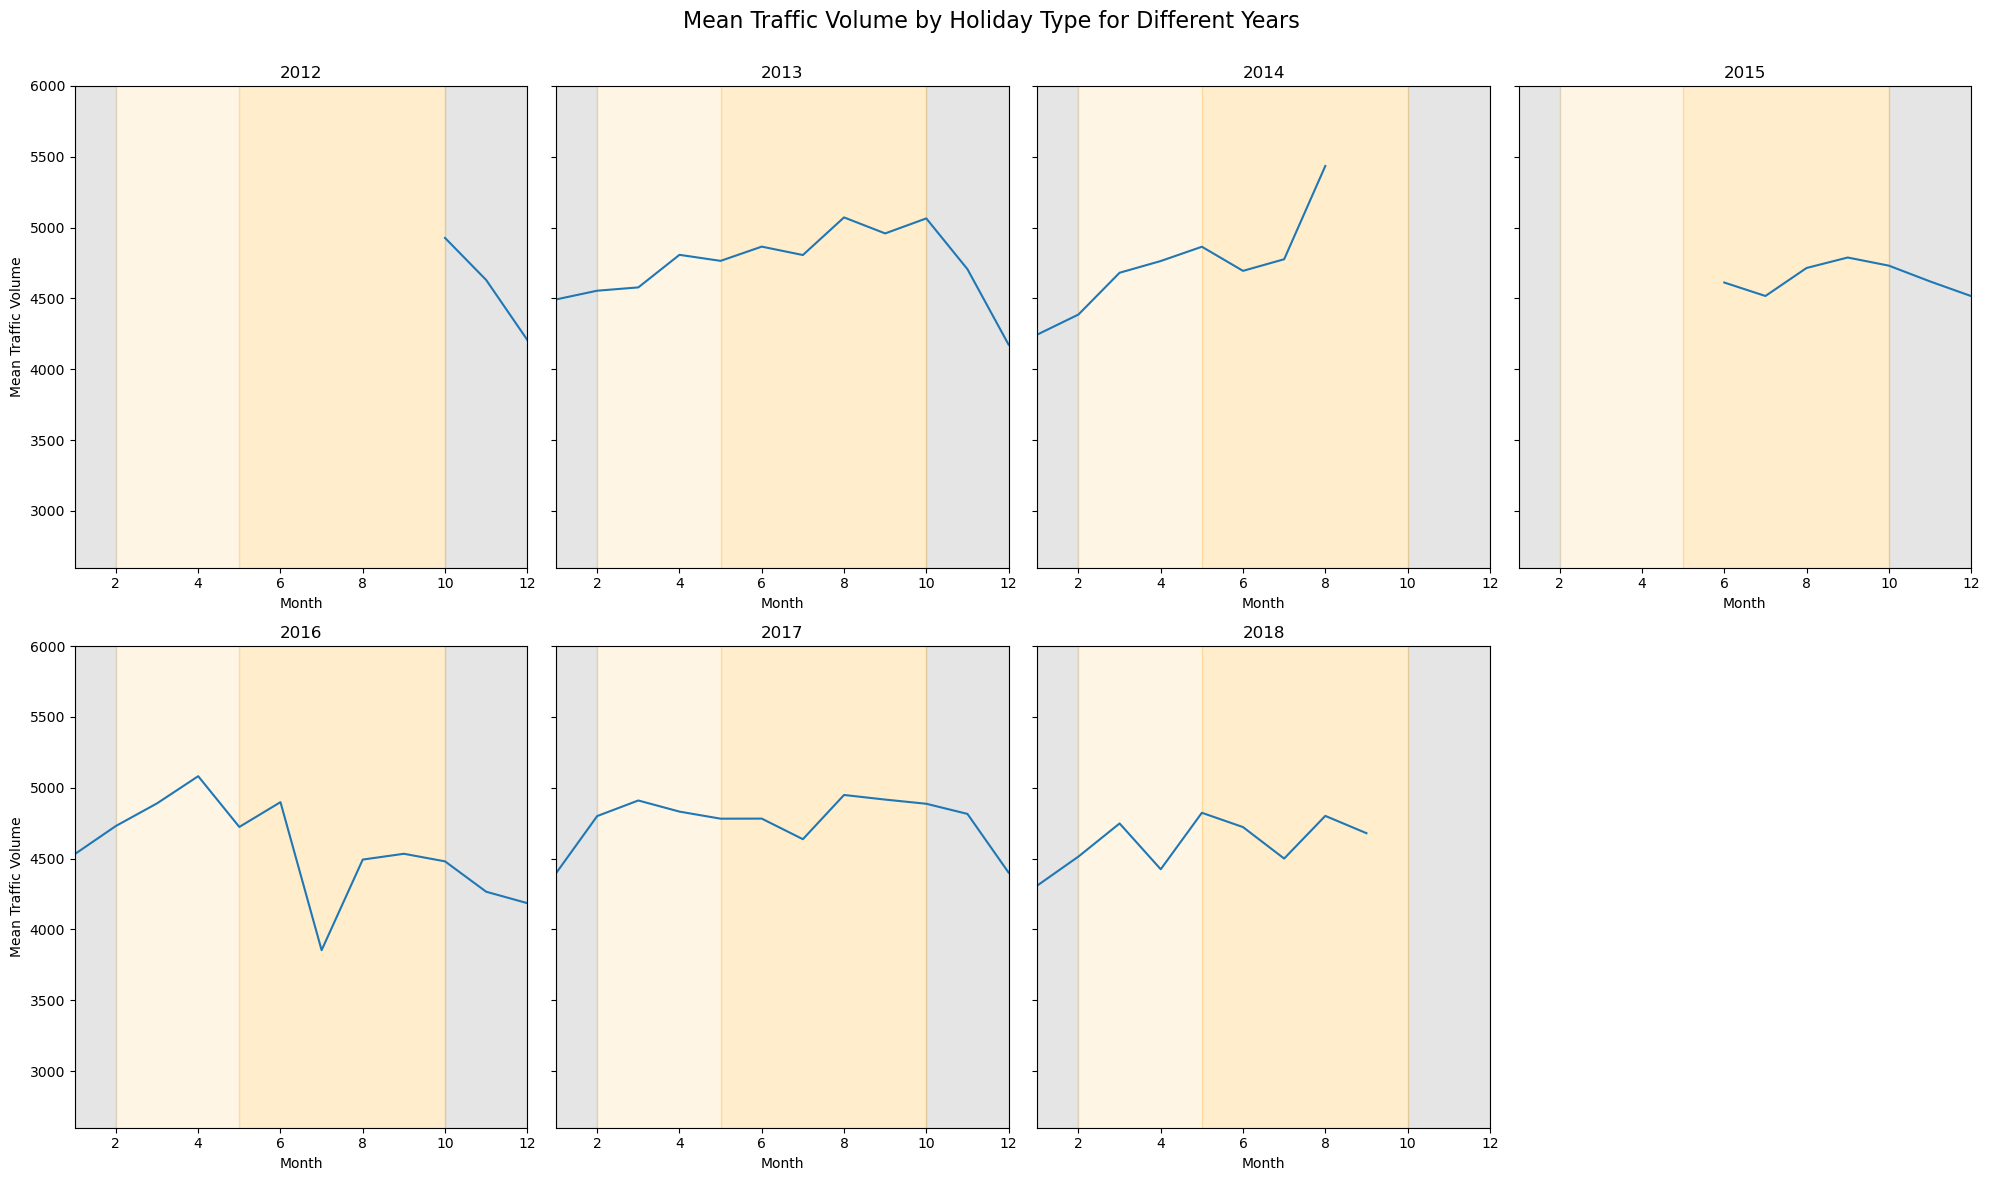

In [116]:
i_94_month = i_94.copy()
i_94_month["date_time"] = pd.to_datetime(i_94_month["date_time"])
i_94_month["month"] = i_94_month["date_time"].dt.month
i_94_month["hour"] = i_94_month["date_time"].dt.hour
i_94_month["year"] = i_94_month['date_time'].dt.year

i_94_month_active_hours = i_94_month.loc[(i_94_month["hour"] >= 7) & (i_94_month["hour"] <= 19)] # Filter for active hours
plot_holiday_traffic_volume_comparison(i_94_month_active_hours, [ 2012, 2013, 2014, 2015, 2016, 2017, 2018], func=1, y_lim=(2600, 6000))

The data collection started on October 2012 up to the end of September 2018, and took a 9-month hiatus between 2014 and 2015.

Forcing my expectation to reflect on the charts, I see a general uptrend of traffic volume from January to the middle of the year and a quick drop by November and hitting minimum by December. The warmer months from May to October has higher traffic volume than the colder November to April months. The idea somewhat holds true for four years starting in 2012. Until the middle of 2016 when the warmer months actually had decreasing traffic volume especially for July that year.  Traffic disruptions like a major road construction may cause such a dip.

### Weather

In [117]:
i_94_weather = i_94.copy()
i_94_weather["date_time"] = pd.to_datetime(i_94_weather["date_time"])
i_94_weather["hour"] = i_94_weather["date_time"].dt.hour

<Axes: ylabel='weather_main'>

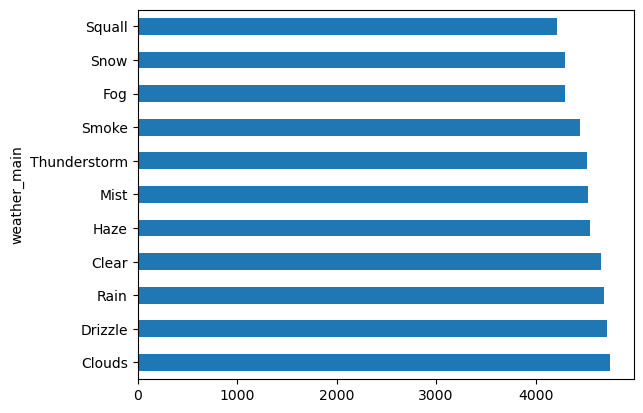

In [191]:
i_94_weather.loc[active_time_bool].groupby(["weather_main"])["traffic_volume"].mean().sort_values(ascending=False).plot.barh()

The bar graph relates to the previous section on MONTHS where traffic is lower on colder months. Colder months mean snow and fog.
Next, we'll see the weather for every hour and how it related to traffic.

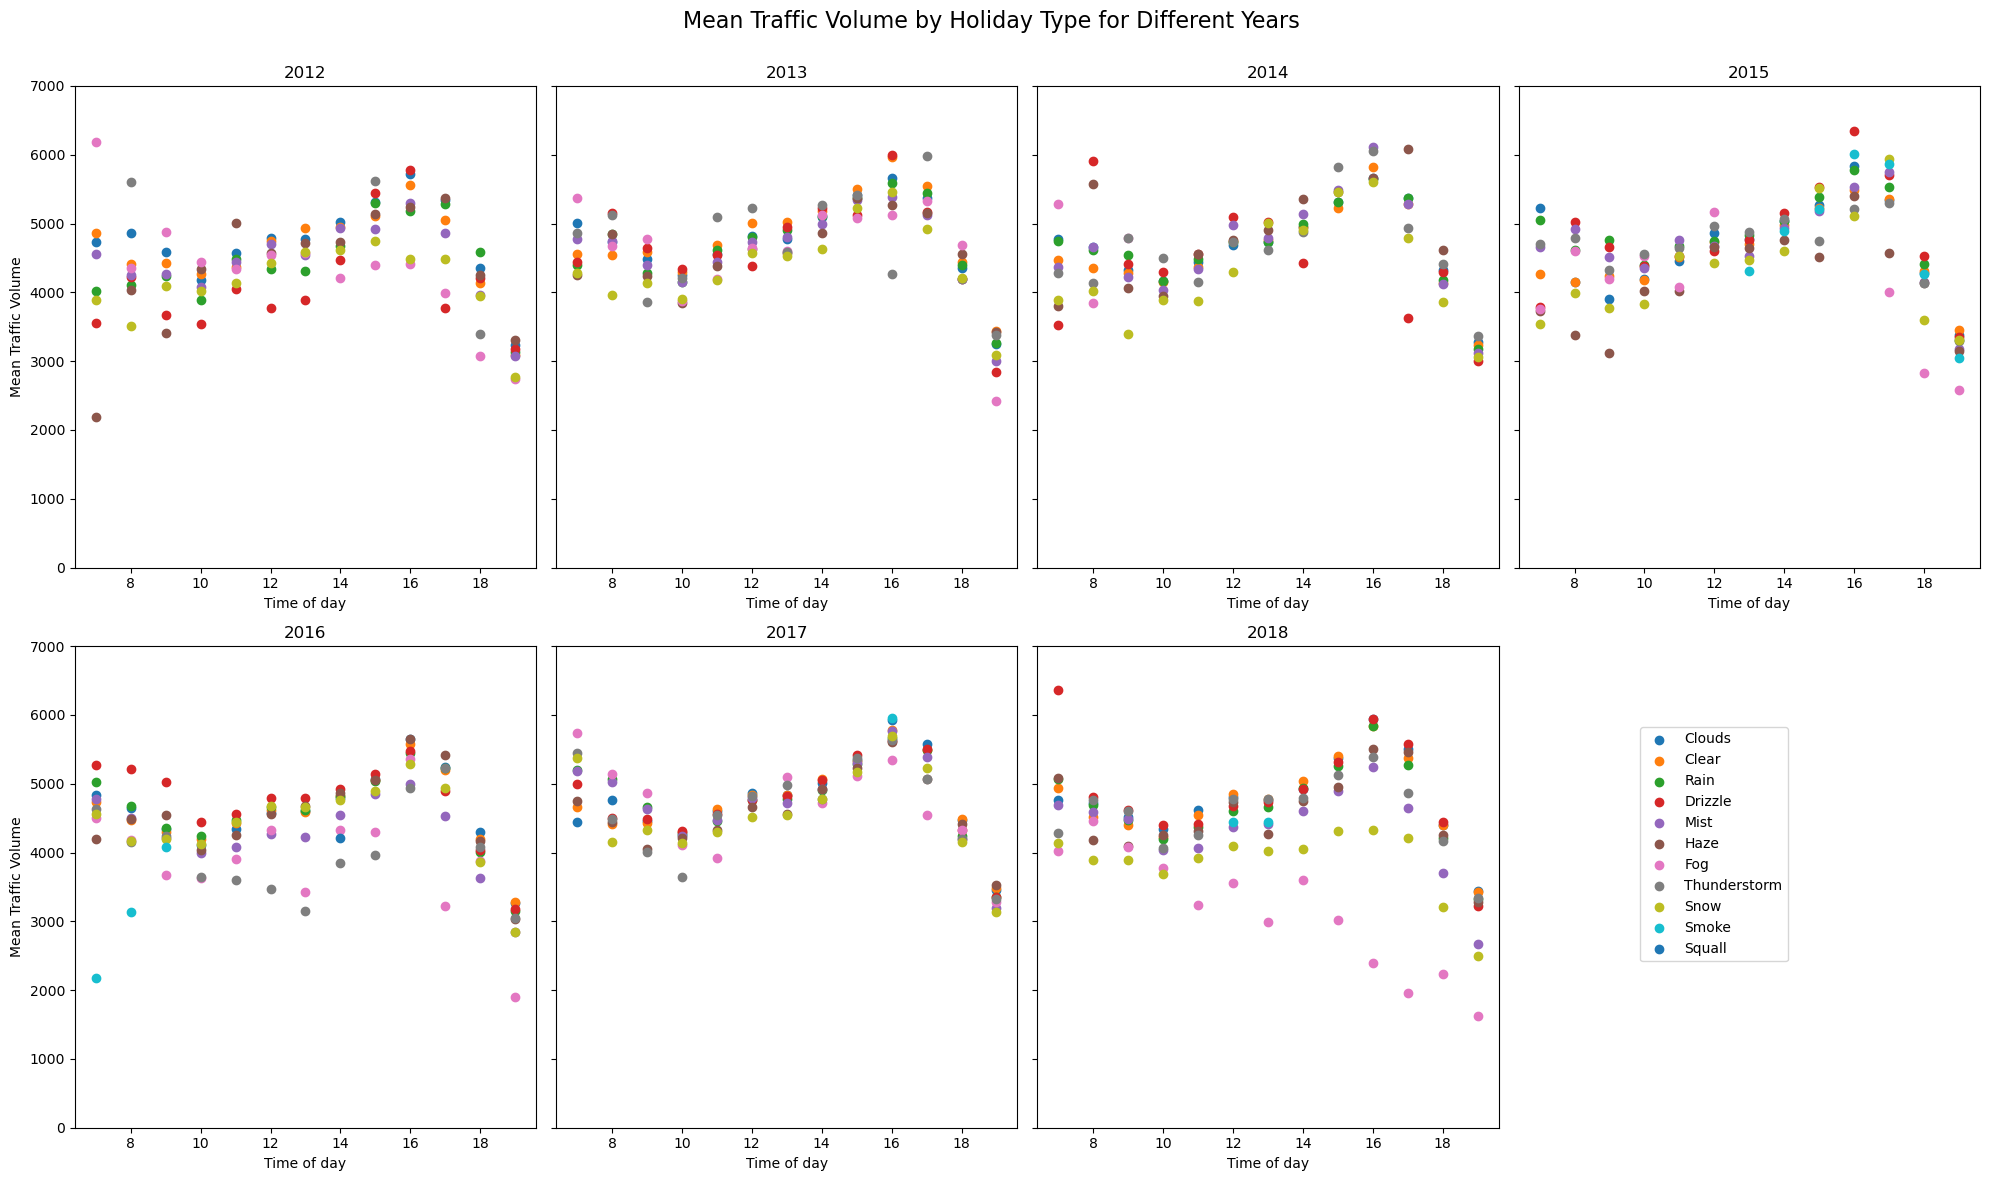

In [190]:

plot_holiday_traffic_volume_comparison(i_94_weather[active_time_bool], [ 2012, 2013, 2014, 2015, 2016, 2017, 2018], groupby_cols=['hour','weather_main'], ptype="scatter")

Understably, not all the hours get all the weather types all the time. Overall the weather type and traffic volume relation is hard to tease apart. But `Snow` and `Fog` dots tend to litter the bottom of the stack.

/home/virgilio/datascience/dataquest/utils.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df['date_time'].dt.year
/home/virgilio/datascience/dataquest/utils.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df['date_time'].dt.hour
/home/virgilio/datascience/dataquest/utils.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

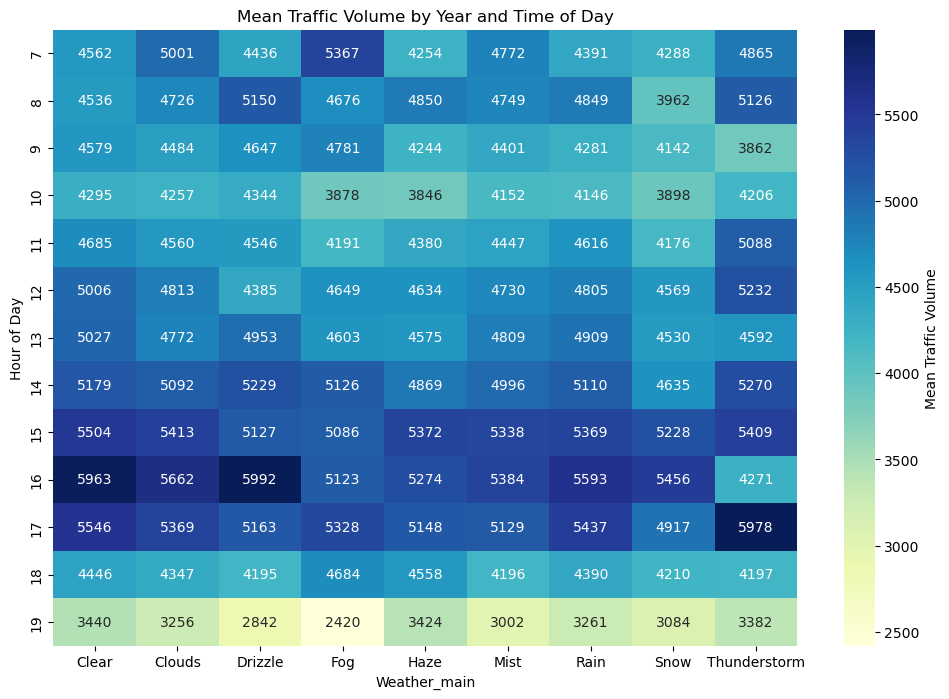

In [121]:
plot_holiday_traffic_volume_heatmap(i_94_weather.loc[active_time_bool], year=2013, gby_col='weather_main')

### Temperature

To have a uniform range of temperatures for our plot we'll select the years where all the months are represented - 2013, 2016, 2017. this way, we'll have better data for both the warm and cold months.

The heatmap showing temperature vs traffic volume, we can't see a clear relation. But now we know that there many instances where the traffic volume is around 4900 and the temperature is about 290 to 300.

If we filter the data down to 4pm to 5pm only data, we see that the same traffic volume can occur over the 250 to 310 degrees temperature. If it's time to go home, people will go home whether it's cold or not. But what if it's time for work? Would they still go to work on time if it's cold?

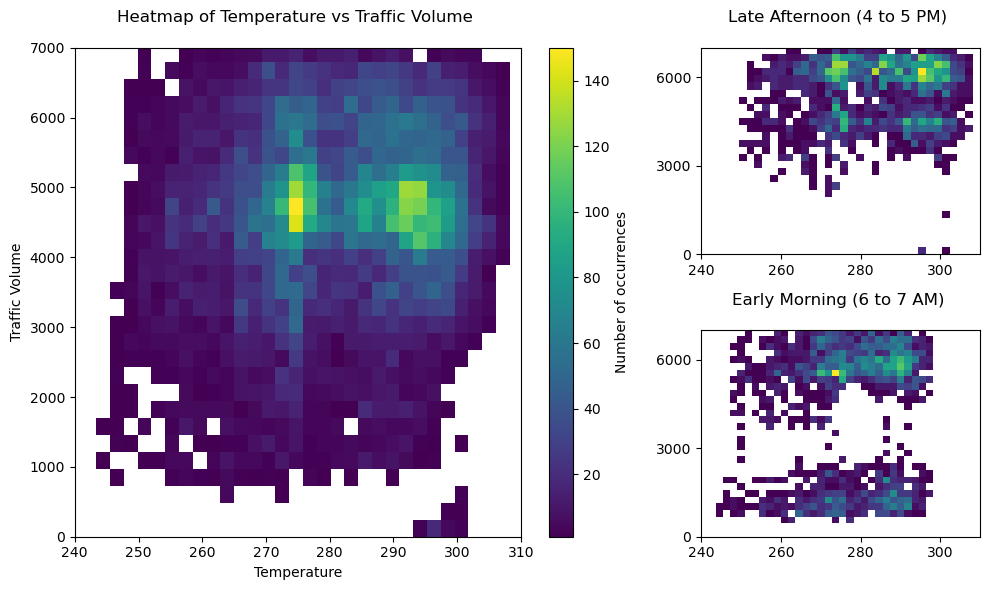

Correlation: 0.07
Correlation: 0.09
Correlation: 0.12


In [178]:
# Create figure
fig = plt.figure(figsize=(10, 6))

gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1], height_ratios=[1, 1])

# Create subplots
ax1 = fig.add_subplot(gs[:, 0]) # Spans all rows in the first column
ax2 = fig.add_subplot(gs[0, 1]) # Top right subplot
ax3 = fig.add_subplot(gs[1, 1]) # Bottom right subplot

plot_heatmap(i_94_weather,"Heatmap of Temperature vs Traffic Volume \n", [7,19], years=[2013, 2016, 2017], ax=ax1)
plot_heatmap(i_94_weather,"Late Afternoon (4 to 5 PM) \n", [16,17], years=[2013, 2016, 2017], ax=ax2,xlabel=None, ylabel=None, cbar_label=None, min_y=0, max_y=7000)
plot_heatmap(i_94_weather,"Early Morning (6 to 7 AM) \n", [6,7], years=[2013, 2016, 2017], ax=ax3, xlabel=None, ylabel=None, cbar_label=None, min_y=0, max_y=7000)


# fig.colorbar(ax1,label='Number of occurrences')
plt.tight_layout()
plt.show()

for t_range in [[6,7,], [16,17], [7,19]]:
    time_bool_w = (i_94_weather['hour'] >= t_range[0]) & (i_94_weather['hour'] <= t_range[1])
    correlation = i_94_weather.loc[time_bool_w,'traffic_volume'].corr(i_94_weather.loc[time_bool_w,'temp'])
    print(f"Correlation: {correlation.round(2)}")

The traffic volume and temperature does not have a clear correlation with each other. Every late afternoon, traffic seem to be high across the range of temperatures. The morning pattern is divided into the extremes. Either the traffic is high or low and almost none in the middle regardless of the temperature.

### CONCLUSION

To summarize here are some points that stand out in this exploration of the I_94 Traffic dataset.

- Timing still is everything. The morning and the afternoon traffic rush plays the same way in this part of the world.
- Weather matters. Cold snowy seasons tend to show lesser traffic volume.
- Different holidays impact traffic differently. 

It's worth exploring the interaction effects of the indicators we've explored